In [82]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [83]:
#Extract Data From API
key = 'f9b723b76349dcbdfd4ecb614b82f4904b7f9c1e'
df = pdr.get_data_tiingo('MSFT', api_key = key)
df.to_csv('MSFT Historical Prices')
df = pd.read_csv('MSFT Historical Prices')
df = pd.DataFrame(df)
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,2015-08-03 00:00:00+00:00,46.81,47.00,46.45,46.98,24125886,42.368777,42.540750,42.042933,42.522647,24125886,0.0,1.0
1,MSFT,2015-08-04 00:00:00+00:00,47.54,47.71,46.68,46.75,33403916,43.029516,43.183387,42.251111,42.314469,33403916,0.0,1.0
2,MSFT,2015-08-05 00:00:00+00:00,47.58,48.41,47.54,47.98,26739584,43.065721,43.816972,43.029516,43.427770,26739584,0.0,1.0
3,MSFT,2015-08-06 00:00:00+00:00,46.62,47.77,46.33,47.71,27368000,42.196803,43.237694,41.934318,43.183387,27368000,0.0,1.0
4,MSFT,2015-08-07 00:00:00+00:00,46.74,46.78,46.26,46.39,19163038,42.305418,42.341623,41.870959,41.988625,19163038,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,MSFT,2020-07-23 00:00:00+00:00,202.54,210.92,202.15,207.19,67457035,202.540000,210.920000,202.150000,207.190000,67457035,0.0,1.0
1253,MSFT,2020-07-24 00:00:00+00:00,201.30,202.86,197.51,200.42,39826989,201.300000,202.860000,197.510000,200.420000,39826989,0.0,1.0
1254,MSFT,2020-07-27 00:00:00+00:00,203.85,203.97,200.86,201.47,30160867,203.850000,203.970000,200.860000,201.470000,30160867,0.0,1.0
1255,MSFT,2020-07-28 00:00:00+00:00,202.02,204.70,201.74,203.61,23251388,202.020000,204.700000,201.740000,203.610000,23251388,0.0,1.0


In [84]:
#Data Clean-up/ Preprocessing 
df.columns = map(lambda x: str(x).capitalize(), df.columns)
df.rename(columns = {'Close price': 'Close'}, inplace = True)
df.shape # 1257 trading days in dataset 
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.dropna() #drop all n/a values 
null_check = df.isnull()
#Checking for Missing Values
for column in null_check.columns.values.tolist():
    print (null_check[column].value_counts())  
df

False    1257
Name: Symbol, dtype: int64
False    1257
Name: Date, dtype: int64
False    1257
Name: Close, dtype: int64
False    1257
Name: High, dtype: int64
False    1257
Name: Low, dtype: int64
False    1257
Name: Open, dtype: int64
False    1257
Name: Volume, dtype: int64
False    1257
Name: Adjclose, dtype: int64
False    1257
Name: Adjhigh, dtype: int64
False    1257
Name: Adjlow, dtype: int64
False    1257
Name: Adjopen, dtype: int64
False    1257
Name: Adjvolume, dtype: int64
False    1257
Name: Divcash, dtype: int64
False    1257
Name: Splitfactor, dtype: int64


,Symbol,Date,Close,High,Low,Open,Volume,Adjclose,Adjhigh,Adjlow,Adjopen,Adjvolume,Divcash,Splitfactor
0,MSFT,2015-08-03,46.81,47.00,46.45,46.98,24125886,42.368777,42.540750,42.042933,42.522647,24125886,0.0,1.0
1,MSFT,2015-08-04,47.54,47.71,46.68,46.75,33403916,43.029516,43.183387,42.251111,42.314469,33403916,0.0,1.0
2,MSFT,2015-08-05,47.58,48.41,47.54,47.98,26739584,43.065721,43.816972,43.029516,43.427770,26739584,0.0,1.0
3,MSFT,2015-08-06,46.62,47.77,46.33,47.71,27368000,42.196803,43.237694,41.934318,43.183387,27368000,0.0,1.0
4,MSFT,2015-08-07,46.74,46.78,46.26,46.39,19163038,42.305418,42.341623,41.870959,41.988625,19163038,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,MSFT,2020-07-23,202.54,210.92,202.15,207.19,67457035,202.540000,210.920000,202.150000,207.190000,67457035,0.0,1.0
1253,MSFT,2020-07-24,201.30,202.86,197.51,200.42,39826989,201.300000,202.860000,197.510000,200.420000,39826989,0.0,1.0
1254,MSFT,2020-07-27,203.85,203.97,200.86,201.47,30160867,203.850000,203.970000,200.860000,201.470000,30160867,0.0,1.0
1255,MSFT,2020-07-28,202.02,204.70,201.74,203.61,23251388,202.020000,204.700000,201.740000,203.610000,23251388,0.0,1.0


Text(0, 0.5, 'Price ($)')

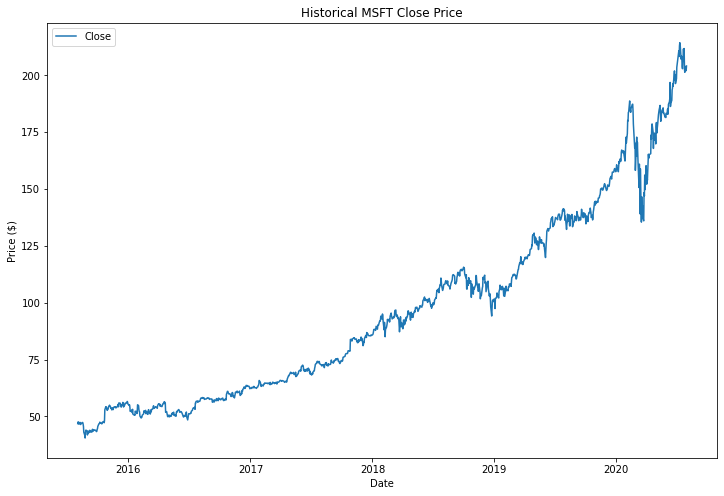

In [85]:
#Visualizing Closing Price History 
df_plot_close = df[['Close', 'Date']]
df_plot_close.plot(kind = 'line', x = 'Date', y = 'Close')
plt.gcf().set_size_inches(12, 8)
plt.title('Historical MSFT Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')

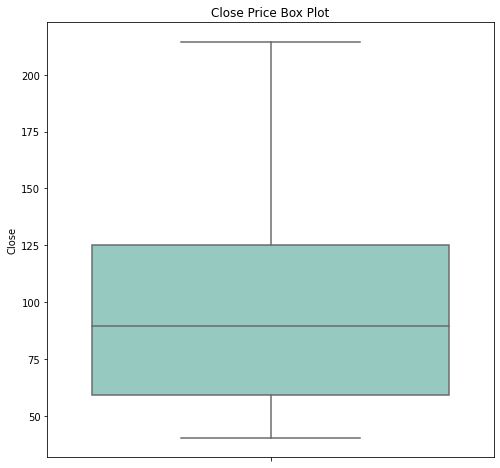

In [86]:
#Visualizing Closing Price History (Boxplot)
sns.boxplot(df_plot_close['Close'], orient = "v", palette="Set3")
plt.show
plt.title("Close Price Box Plot")
plt.gcf().set_size_inches(8, 8)

In [87]:
#Information on Closing Price History
df_plot_close[['Close']].describe()

,Close
count,1257.000000
mean,96.440863
std,41.911564
min,40.470000
25%,59.200000
50%,89.710000
75%,125.010000
max,214.320000


In [88]:
#Normalization - MinMaxScaler
df_close = df[['Close', 'Date']]
df_close.set_index('Date', inplace = True)
df_close.head()

,Close
Date,
2015-08-03,46.81
2015-08-04,47.54
2015-08-05,47.58
2015-08-06,46.62
2015-08-07,46.74


In [89]:
#Scaling Data
mms = MinMaxScaler(feature_range = (0,1))
scaled_close = mms.fit_transform(df_close).reshape(-1,1)

In [90]:
#Splitting Train vs Test Data
train_ratio = 0.80
rolling = 60
train_data = np.array(scaled_close[:int(len(df_close)*train_ratio)])
test_data = np.array(scaled_close[int(len(train_data))-rolling:])

#Shapes
traind_shape = train_data.shape
tstd_shape = test_data.shape 
traind_shape, tstd_shape


((1005, 1), (312, 1))

In [91]:
#Seperating x/y Training Sets
x_train = []
y_train = []
for i in range(rolling, len(train_data)):
    x_train.append(train_data[i-rolling:i,0])
    y_train.append(train_data[i,0])

In [92]:
#Seperating x/y Testing Sets
x_test = []
y_test = df_close[int(len(train_data)):]
for i in range(rolling, len(test_data)):
    x_test.append(test_data[i-rolling:i])

In [93]:
#Reshaping x/y Sets
x_train, y_train = np.array(x_train), np.array(y_train)
x_train_shape = x_train.shape[0]
x_train = np.reshape(x_train, (x_train_shape, rolling, 1))
y_train = np.reshape(y_train, (-1,1))
x_test, y_test = np.array(x_test), np.array(y_test)
x_test_shape = x_test.shape[0]
x_test = np.reshape(x_test, (x_test_shape, rolling, 1))
y_test = np.reshape(y_test, (-1,1))

In [104]:
#LSTM Model
lstm = Sequential()
lstm.add(LSTM(rolling, return_sequences = True, input_shape = (rolling, 1)))
lstm.add(Dropout(0.2))

lstm.add(LSTM(rolling, return_sequences = True))
lstm.add(Dropout(0.2))

lstm.add(LSTM(rolling))
lstm.add(Dropout(0.2))

lstm.add(Dense(1))
lstm.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_squared_error'])


In [105]:
#LSTM Model Summary
lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 60, 60)            14880     
_________________________________________________________________
lstm_24 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
lstm_25 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dropout_19 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [121]:
#LSTM Model Fitting
lstm.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=60,batch_size=50,verbose=1)

Epoch 1/60
19/19 [==============================] - 2s 93ms/step - loss: 5.1082e-04 - mean_squared_error: 5.1082e-04 - val_loss: 26848.3301 - val_mean_squared_error: 26848.3301
Epoch 2/60
19/19 [==============================] - 2s 88ms/step - loss: 5.4122e-04 - mean_squared_error: 5.4122e-04 - val_loss: 26857.1641 - val_mean_squared_error: 26857.1641
Epoch 3/60
19/19 [==============================] - 2s 86ms/step - loss: 3.7357e-04 - mean_squared_error: 3.7357e-04 - val_loss: 26854.1738 - val_mean_squared_error: 26854.1758
Epoch 4/60
19/19 [==============================] - 2s 94ms/step - loss: 4.0980e-04 - mean_squared_error: 4.0980e-04 - val_loss: 26862.5527 - val_mean_squared_error: 26862.5566
Epoch 5/60
19/19 [==============================] - 2s 92ms/step - loss: 3.7171e-04 - mean_squared_error: 3.7171e-04 - val_loss: 26854.4844 - val_mean_squared_error: 26854.4844
Epoch 6/60
19/19 [==============================] - 2s 93ms/step - loss: 3.6947e-04 - mean_squared_error: 3.6947e-0

In [122]:
#Train/ Test Data Predictions
x_train_p = lstm.predict(x_train)
x_test_p = lstm.predict(x_test)

In [123]:
#Rescaling Data
x_train_p = mms.inverse_transform(x_train_p)
x_test_p = mms.inverse_transform(x_test_p)
y_train_scaled = mms.inverse_transform(y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


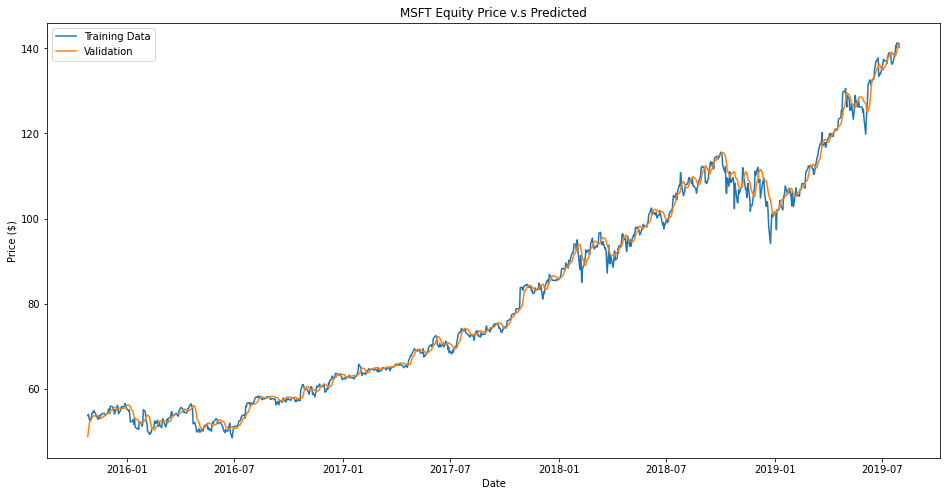

In [150]:
#Train Data vs Train Validation (Graph)
training_train = df_close[rolling:int(len(train_data))]
training_train['Predicted Close'] = x_train_p
plt.figure(figsize = (16,8))
plt.title('MSFT Equity Price v.s Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(training_train['Close'])
plt.plot(training_train[['Predicted Close']])
plt.legend(['Training Data', 'Validation'])
plt.show()


In [151]:
#Training Model Valuation (RMSE, MSE, R^2)
MSE = np.mean(x_train_p - y_train_scaled)**2
RMSE = np.sqrt(MSE)
R2 = r2_score(x_train_p, y_train_scaled)
print ('Mean Squared Error:', MSE, '\nRoot Mean Squared Error:', RMSE, '\nR^2:', R2)


Mean Squared Error: 0.03768755948423286 
Root Mean Squared Error: 0.19413283978820497 
R^2: 0.9952643275964871


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


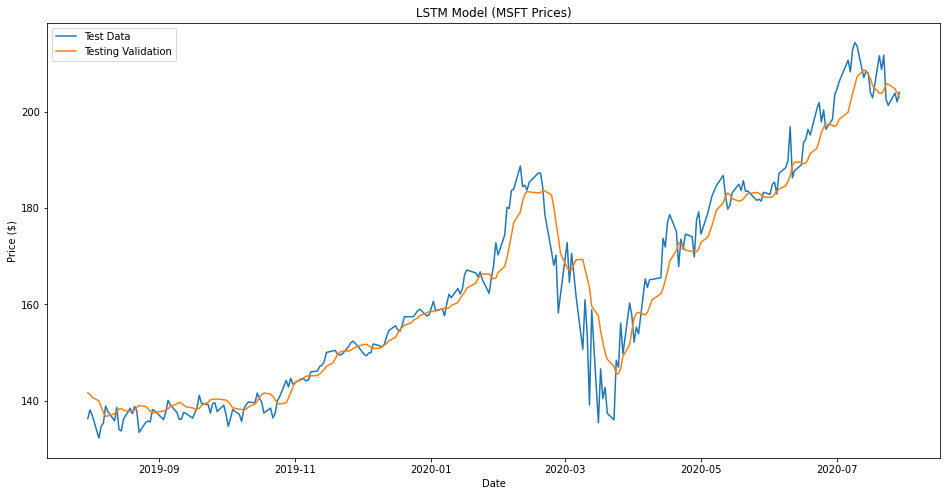

In [152]:
#Test Data vs Test Validation (Graph)
validation = df_close[int(len(train_data)):]
validation['Predicted Close'] = x_test_p
plt.figure(figsize = (16,8))
plt.title('LSTM Model (MSFT Prices)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(validation['Close'])
plt.plot(validation['Predicted Close'])
plt.legend(['Test Data', 'Testing Validation'])
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


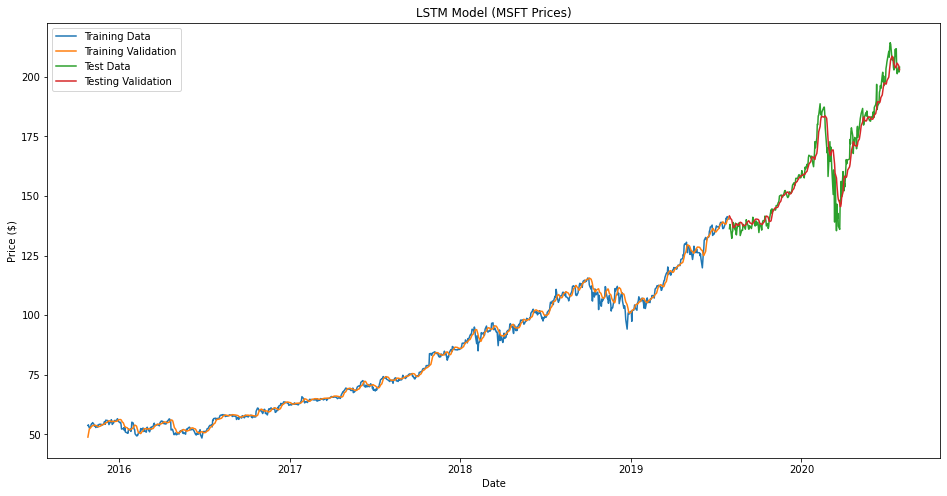

In [153]:
#Data vs Validation (Graph)
training_train = df_close[rolling:int(len(train_data))]
training_train['Predicted Close'] = x_train_p
validation = df_close[int(len(train_data)):]
validation['Predicted Close'] = x_test_p
plt.figure(figsize = (16,8))
plt.title('LSTM Model (MSFT Prices)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(training_train['Close'])
plt.plot(training_train[['Predicted Close']])
plt.plot(validation['Close'])
plt.plot(validation['Predicted Close'])
plt.legend(['Training Data', 'Training Validation', 'Test Data', 'Testing Validation' ])
plt.show()


In [130]:
#Training Model Valuation (RMSE, MSE, R^2)
MSE = np.mean(x_test_p - y_test)**2
RMSE = np.sqrt(MSE)
R2 = r2_score(x_test_p, y_test)
print ('Mean Squared Error:', MSE, '\nRoot Mean Squared Error:', RMSE, '\nR^2:', R2)

Mean Squared Error: 0.1710575862259165 
Root Mean Squared Error: 0.41359108576698855 
R^2: 0.9419522159705571


In [131]:
#Retrain Using Whole Test Data
df_final = np.array(scaled_close)
x = []
y = []
train_amt = 60
for i in range(train_amt, len(df_final)):
    x.append(df_final[i-train_amt:i,0])
    y.append(df_final[i,0])
x, y = np.array(x), np.array(y)
x_shape = x.shape[0]
x = np.reshape(x, (x_shape, train_amt, 1))
y = np.reshape(y, (-1,1))

In [132]:
#LSTM Model #2
#LSTM Model
lstm_final = Sequential()
lstm_final.add(LSTM(rolling, return_sequences = True, input_shape = (rolling, 1)))
lstm_final.add(Dropout(0.2))

lstm_final.add(LSTM(rolling, return_sequences = True))
lstm_final.add(Dropout(0.2))

lstm_final.add(LSTM(rolling))
lstm_final.add(Dropout(0.2))

lstm_final.add(Dense(1))
lstm_final.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_squared_error'])


In [133]:
#LSTM Model #2 Fitting
lstm_final.fit(x,y,epochs=60,batch_size=60,verbose=1)

Epoch 1/60
20/20 [==============================] - 2s 93ms/step - loss: 0.0368 - mean_squared_error: 0.0368
Epoch 2/60
20/20 [==============================] - 2s 93ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 3/60
20/20 [==============================] - 2s 91ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 4/60
20/20 [==============================] - 2s 87ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 5/60
20/20 [==============================] - 2s 92ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/60
20/20 [==============================] - 2s 90ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 7/60
20/20 [==============================] - 2s 90ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/60
20/20 [==============================] - 2s 87ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 9/60
20/20 [==============================] - 2s 91ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 10/60
20/20 [

In [154]:
#Projection Set
steps = 15
df_final = pd.DataFrame(scaled_close)
for x in range (0,steps):
    data = np.array(df_final[len(df_final)-train_amt + x:])
    x_project = np.array(data)
    x_project_shape = x_project.shape[0]
    x_project = np.reshape(x_project, (1, -1, 1))
    projected_data = pd.DataFrame(lstm_final.predict(x_project))
    df_final = df_final.append(projected_data)

In [155]:
#Rescaling the Dataset
df_final = mms.inverse_transform(df_final)

In [156]:
#Creating a Function For Adding Business Days
import datetime
def add_bdays(from_date, add_days):
    bdays_add = add_days
    curr_date = from_date
    while bdays_add > 0:
        curr_date += datetime.timedelta(days=1)
        weekday = curr_date.weekday()
        if weekday >= 5: 
            continue
        bdays_add -= 1
    return curr_date

In [157]:
#Creating Date Index With 10 Days Forward 
df_date = df[['Date']]
start_date = str(df_date['Date'][0])
end_date = df_date['Date'].iloc[-1]
proj_dates = []
for x in range(1,steps+1):
    proj_dates.append(add_bdays(end_date,x))
df_proj_dates = pd.DataFrame(proj_dates)
df_append_date = df_date['Date'].append(df_proj_dates)
date_array = np.array(df_append_date)
date_array.shape, df_final.shape

((1272, 1), (1272, 1))

In [158]:
#Creating New DataFrame For Forward Dates
df_new = pd.DataFrame(df_final, columns=['Projected Close'])
df_new['Date'] = date_array
df_new.set_index('Date', inplace = True)
projected_df = df_new.tail(steps)
projected_df

,Projected Close
Date,
2020-07-30,204.552019
2020-07-31,203.917651
2020-08-03,203.516932
2020-08-04,203.335167
2020-08-05,203.342255
2020-08-06,203.511886
2020-08-07,203.815832
2020-08-10,204.232136
2020-08-11,204.744353


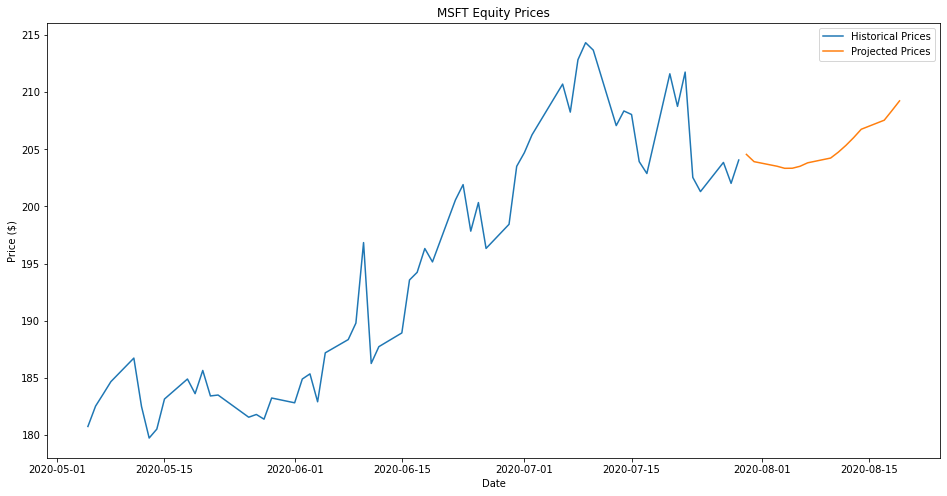

In [159]:
#Projected Values
plt.figure(figsize = (16,8))
plt.title('MSFT Equity Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(df_close.iloc[-rolling:])
plt.plot(projected_df)
plt.legend(['Historical Prices', 'Projected Prices'])
plt.show()